
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/spectrum_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[spectrum_analysis.ipynb](../_static/notebooks/spectrum_analysis.ipynb) |
[spectrum_analysis.py](../_static/notebooks/spectrum_analysis.py)
</div>


# Spectral analysis with Gammapy

## Prerequisites 

- Understanding how spectral extraction is performed in Cherenkov astronomy, in particular regarding OFF background measurements. 
- Understanding the basics data reduction and modeling/fitting process with the gammapy library API as shown in the [first gammapy analysis with the gammapy library API tutorial](analysis_2.ipynb)

## Context

While 3D analysis allows in principle to deal with complex situations such as overlapping sources, in many cases, it is not required to extract the spectrum of a source. Spectral analysis, where all data inside a ON region are binned into 1D datasets, provides a nice alternative. 

In classical Cherenkov astronomy, it is used with a specific background estimation technique that relies on OFF measurements taken in the field-of-view in regions where the background
rate is assumed to be equal to the one in the ON region. 

This allows to use a specific fit statistics for ON-OFF measurements, the wstat (see `~gammapy.stats.fit_statistics`), where no background model is assumed. Background is treated as a set of nuisance parameters. This removes some systematic effects connected
to the choice or the quality of the background model. But this comes at the expense of larger statistical uncertainties on the fitted model parameters.

**Objective: perform a full region based spectral analysis of 4 Crab observations of  H.E.S.S. data release 1 and fit the resulting datasets.**

## Introduction

Here, as usual, we use the `~gammapy.data.DataStore` to retrieve a list of selected observations (`~gammapy.data.Observations`). Then, we define the ON region containing the source and the geometry of the `~gammapy.datasets.SpectrumDataset` object we want to produce. We then create the corresponding dataset Maker. 

We have to define the Maker object that will extract the OFF counts from reflected regions in the field-of-view. To ensure we use data in an energy range where the quality of the IRFs is good enough we also create a safe range Maker.

We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry.

We can then explore the resulting datasets and look at the cumulative signal and significance of our source. We finally proceed with model fitting. 

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define a geometry of the spectrum we want to produce:
    - Create a `~regions.CircleSkyRegion` for the ON extraction region
    - Create a `~gammapy.maps.MapAxis` for the energy binnings: one for the reconstructed (i.e. measured) energy, the other for the true energy (i.e. the one used by IRFs and models)
- Create the necessary makers : 
    - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker`
    - the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
    - and the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce a `~gammapy.datasets.SpectrumDatasetOnOff`
    - Append it to list of datasets
- Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.


## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.17
numpy: 1.18.1
astropy 4.0
regions 0.4


In [3]:
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula (simulated events for now).

We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [4]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [23523, 23526, 23559, 23592]
observations = datastore.get_observations(obs_ids)

## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [5]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region.
To make sure the off regions don't contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there's only one known gamma-ray source near the Crab nebula: the AGN called [RGB J0521+212](http://gamma-sky.net/#/cat/tev/23) at GLON = 183.604 deg and GLAT = -8.708 deg.

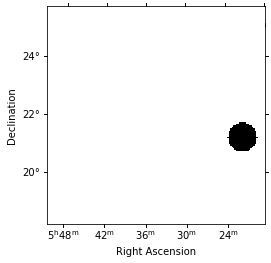

In [6]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot();

## Run data reduction chain

We begin with the configuration of the maker classes:

In [7]:
e_reco = np.logspace(-1, np.log10(40), 40) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 200) * u.TeV
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

In [8]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "aeff", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [9]:
%%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 2.63 s, sys: 117 ms, total: 2.75 s
Wall time: 2.76 s


## Plot off regions

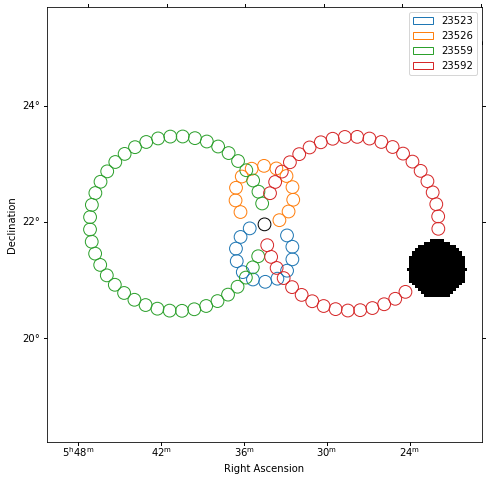

In [10]:
plt.figure(figsize=(8, 8))
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

## Source statistic

Next we're going to look at the overall source statistics in our signal region.

In [11]:
info_table = datasets.info_table(cumulative=True)

In [12]:
info_table

name,livetime,n_on,background,excess,significance [1],background_rate,gamma_rate,a_on,n_off,a_off,alpha
,s,,,,,1 / s,1 / s,,,,
str7,float64,float32,float64,float64,float64,float64,float64,float64,float32,float64,float64
stacked,1581.7367584109306,172.0,13.5,158.5,21.108139320737816,0.008534922090046502,0.10020630750165709,1.0,162.0,12.0,0.08333333333333333
stacked,3154.4234824180603,365.0,32.000003814697266,333.0,29.933816384023682,0.010144485670062058,0.10556604141963048,1.0,384.0,12.0,0.0833333358168602
stacked,4732.546999931335,512.0,41.902442932128906,470.09759521484375,37.371271349232565,0.008854099691505836,0.09933289520878807,1.0,790.0,18.853315353393555,0.05304107069969177
stacked,6313.811640620232,636.0,52.54133224487305,583.4586791992188,41.98855287814946,0.008321650254316377,0.09240989633670846,1.0,1173.0,22.325281143188477,0.04479226842522621


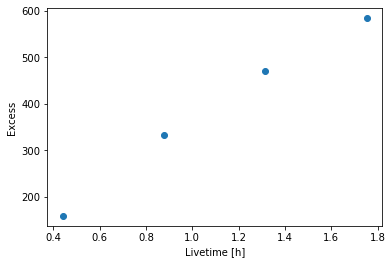

In [13]:
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");

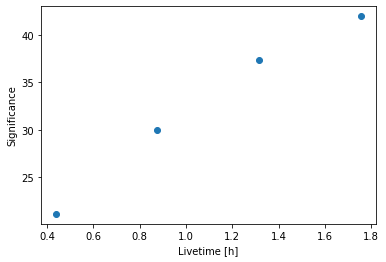

In [14]:
plt.plot(
    info_table["livetime"].to("h"),
    info_table["significance"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Significance");

Finally you can write the extrated datasets to disk using the OGIP format (PHA, ARF, RMF, BKG, see [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html) for details):

In [15]:
path = Path("spectrum_analysis")
path.mkdir(exist_ok=True)

In [16]:
for dataset in datasets:
    dataset.to_ogip_files(outdir=path, overwrite=True)

If you want to read back the datasets from disk you can use:

In [17]:
datasets = Datasets()
for obs_id in obs_ids:
    filename = path / f"pha_obs{obs_id}.fits"
    datasets.append(SpectrumDatasetOnOff.from_ogip_files(filename))

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

In [18]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="crab")

for dataset in datasets:
    dataset.models = model

fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model.copy()

In [19]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 52
	total stat : 122.01



(0.1, 40)

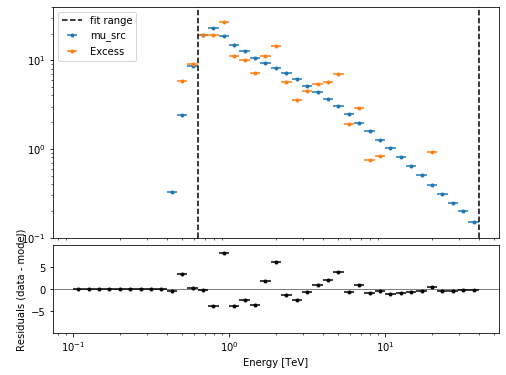

In [20]:
plt.figure(figsize=(8, 6))
ax_spectrum, ax_residual = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)

## Compute Flux Points

To round up our analysis we can compute flux points by fitting the norm of the global model in energy bands. We'll use a fixed energy binning for now:

In [21]:
e_min, e_max = 0.7, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

Now we create an instance of the `~gammapy.estimators.FluxPointsEstimator`, by passing the dataset and the energy binning:

In [22]:
fpe = FluxPointsEstimator(e_edges=e_edges, source="crab")
flux_points = fpe.run(datasets=datasets)

/Users/terrier/Code/gammapy-dev/gammapy-docs/build/v0.17/gammapy/gammapy/estimators/parameter_estimator.py:172: RuntimeWarning: invalid value encountered in sqrt
  {"sqrt_ts": np.sqrt(res), "ts": res, "null_value": null_value}


Here is a the table of the resulting flux points:

In [23]:
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [4],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64
0.859,0.737,1.002,4.041e-11,1.077e-11,9.177e-12,2.983e-11,0.969,18.394,True,0.086,0.089,0.084,1.152,20.687,427.948,0,0.200 .. 5.000,188.877 .. 679.454,49 .. 31,3.914e-11,4.655e-11,3.459e-12,3.612e-12,3.395e-12
1.261,1.002,1.588,1.488e-11,8.850e-12,1.095e-11,2.368e-11,0.972,12.585,True,0.098,0.094,0.088,1.164,20.513,420.787,0,0.200 .. 5.000,172.378 .. 615.327,31 .. 36,1.446e-11,1.733e-11,1.456e-12,1.392e-12,1.306e-12
1.852,1.588,2.160,5.482e-12,3.151e-12,5.786e-12,1.881e-11,1.196,9.948,True,0.131,0.155,0.143,1.519,15.286,233.671,0,0.200 .. 5.000,115.961 .. 242.748,27 .. 12,6.559e-12,8.329e-12,7.205e-13,8.522e-13,7.865e-13
2.518,2.160,2.936,2.466e-12,1.927e-12,4.812e-12,1.564e-11,1.251,9.175,True,0.170,0.185,0.169,1.638,13.945,194.471,0,0.200 .. 5.000,96.549 .. 175.201,10 .. 11,3.085e-12,4.038e-12,4.180e-13,4.573e-13,4.157e-13
3.697,2.936,4.656,9.083e-13,1.583e-12,5.741e-12,1.242e-11,0.939,14.941,True,0.161,0.167,0.149,1.289,10.703,114.548,0,0.200 .. 5.000,60.495 .. 213.695,17 .. 11,8.528e-13,1.171e-12,1.461e-13,1.518e-13,1.358e-13
5.429,4.656,6.330,3.346e-13,5.637e-13,3.034e-12,9.860e-12,1.136,8.759,True,0.260,0.286,0.246,1.749,8.141,66.271,0,0.200 .. 5.000,38.261 .. 80.956,9 .. 5,3.799e-13,5.852e-13,8.689e-14,9.573e-14,8.244e-14
7.971,6.330,10.037,1.232e-13,4.631e-13,3.620e-12,7.830e-12,1.040,12.416,True,0.272,0.297,0.252,1.680,6.855,46.995,0,0.200 .. 5.000,32.844 .. 80.536,5 .. 4,1.281e-13,2.070e-13,3.349e-14,3.658e-14,3.111e-14
11.703,10.037,13.647,4.539e-14,1.649e-13,1.913e-12,6.217e-12,0.901,10.500,True,0.432,0.492,0.373,2.009,3.369,11.351,0,0.200 .. 5.000,15.516 .. 38.276,0 .. 1,4.089e-14,9.118e-14,1.962e-14,2.233e-14,1.692e-14


Now we plot the flux points and their likelihood profiles. For the plotting of upper limits we choose a threshold of TS < 4.

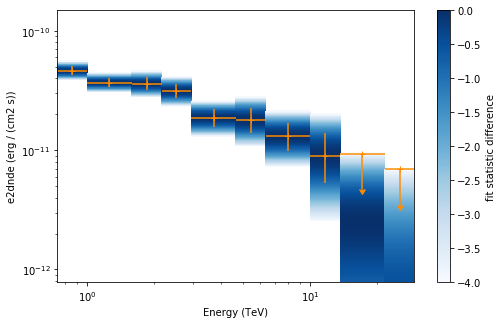

In [24]:
plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

The final plot with the best fit model, flux points and residuals can be quickly made like this: 

In [25]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint
)

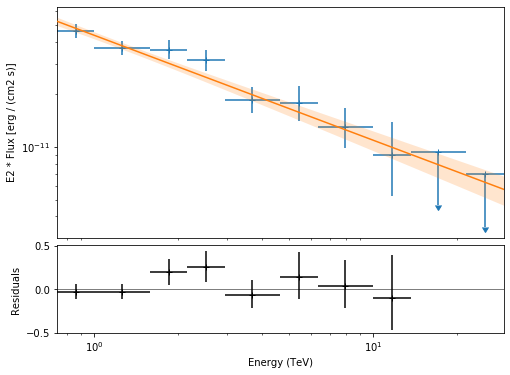

In [26]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model. For this we first stack the individual datasets:

In [27]:
dataset_stacked = Datasets(datasets).stack_reduce()

Again we set the model on the dataset we would like to fit (in this case it's only a single one) and pass it to the `~gammapy.modeling.Fit` object:

In [28]:
dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

In [29]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 29
	total stat : 29.05



In [30]:
model_best_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.600e+00,,nan,nan,False,5.850e-02
amplitude,2.723e-11,cm-2 s-1 TeV-1,nan,nan,False,1.255e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00


In [31]:
model_best_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.601e+00,,nan,nan,False,6.346e-02
amplitude,2.723e-11,cm-2 s-1 TeV-1,nan,nan,False,1.305e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00


Finally, we compare the results of our stacked analysis to a previously published Crab Nebula Spectrum for reference. This is available in `~gammapy.modeling.models.create_crab_spectral_model`.

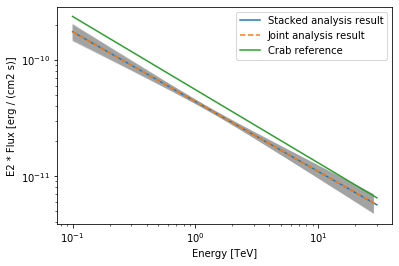

In [32]:
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs, label="Crab reference"
)
plt.legend()

## Exercises

Now you have learned the basics of a spectral analysis with Gammapy. To practice you can continue with the following exercises:

- Fit a different spectral model to the data.
  You could try `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel` or `~gammapy.modeling.models.LogParabolaSpectralModel`.
- Compute flux points for the stacked dataset.
- Create a `~gammapy.estimators.FluxPointsDataset` with the flux points you have computed for the stacked dataset and fit the flux points again with obe of the spectral models. How does the result compare to the best fit model, that was directly fitted to the counts data?

## What next?

The methods shown in this tutorial is valid for point-like or midly extended sources where we can assume that the IRF taken at the region center is valid over the whole region. If one wants to extract the 1D spectrum of a large source and properly average the response over the extraction region, one has to use a different approach explained in [the extended source spectral analysis tutorial](extended_source_spectral_analysis.ipynb).